In [1]:
from pya import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, widgets
%matplotlib qt5
%matplotlib inline

In [2]:
asen = Asig("samples/sentence.wav", label='sentence')
asen.play()

resample as sr is exotic
Play Sound.


Asig('sentence'): 1 x 61632 @ 24000 Hz = 2.568 s

resample as sr is exotic
Play Sound.


Asig('sentence'): 1 x 61632 @ 24000 Hz = 2.568 s

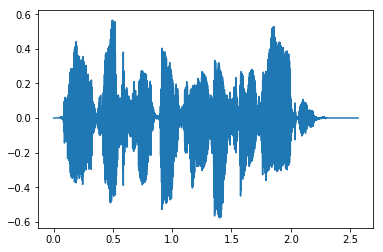

In [4]:
asen.play().plot()

In [5]:
asen.play2()

resample as sr is exotic
Play Sound.


Asig('sentence'): 1 x 61632 @ 24000 Hz = 2.568 s